In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from athena import Athena
import matplotlib.pyplot as plt

# How to Run Simulations with Athena

### First Step: Initialize Simulation Parameters

Athena enables you to simulate Single Cell CRISPR Screens. Before you can run simulations you need to provide Athena with simulation parameters most noteably: on target activity, off target activity, type of CRISPR pertubation, number of Transcription Factors (TFs), number of E-genes, number of kinases, and the number of signalling cascades you want to simulate. Additional parameters you can provide include the number of cells per condition to simulate to where directory to store simulation data.

It's important to note that when initializing the Athena class is when you pass the parameters to Athena. All methods afterwards do not require or do not take any parameters.

In [2]:
athena = Athena(negenes=200,
                nkinases=15,
                ncascades=3, 
                ncpus=3, nbatches=4,
                ngrnas_per_target=1,
                # crispr_type='Knockout',
                ncells_per_condition=1000)


# athena.create_network()
# athena.initialize_kinetics()

Initiate Environmental Parameters...
Check the caches...
Setup Simulator Directory...
Check Network Parameters...
Check gRNA Parameters...
Check Simulation Parameters...
Check Downsampling Parameters...


### Second Step: Create Gene Regulatory Network and Signalling Cascade

Both Gene Regulator Networks and Signalling Cascades are created using Modular Sampling method originally developed by GeneNetWeaver. This modular sampling method allows us to capture the scale-free and modular nature of biologically networks in comparison to an other scale-free random sampling method. Thereby allowing us to better represent the flow between reactions that occurs in biological networks.

**No Parameters Avaliable**

In [3]:
athena.create_network()

Created Network...


### Third Step:  Initialize Reaction Kinectics

Next we need to initialize reaction kinetics of both our GRN and Signalling Cascade.

**No Parameters Avaliable**

In [4]:
athena.initialize_kinetics()

Initialized Kinetics...


### Fourth Step: Create Guide RNA Metadata

Creating gRNA Metadata and Perturbation Coefficient Matrix.

**Parameters Avaliable**

- crispr_type: The type of CRISPR perturbation that you want to simulate. Only three types of CRISPR perturbations are currently supported: Interference, Activation, and Knockout

In [5]:
athena.generate_grnas(crispr_type='interference', on_target=0.0, off_target=0)

100%|██████████| 26/26 [00:00<00:00, 120.35it/s]


### Fifth Step:  Compile Reactions for Simulation

Once we have initialized the kinetics and create gRNA metadata we need to convert all of this information in complied affinity and propensity probability calculation. This is required for the novel GPU Based Gillespie Algorithm.

**No Parameters Avaliable**

In [6]:
athena.compiling()

Simulation: athena Starting to Processing Batch 0...
Simulation: athena Starting to Processing Batch 1...
Simulation: athena Starting to Processing Batch 2...
Simulation: athena Finished Processing Batch 1...
Simulation: athena Finished Processing Batch 0...
Simulation: athena Starting to Processing Batch 3...
Simulation: athena Finished Processing Batch 2...
Simulation: athena Finished Processing Batch 3...


### Sixith Step: Run Gillispie Tau Leaping Algorithm

Now that we have compiled the chemical reactions we can run our simulations. Athena uses a opencl implementation of the Gillespie Tau-Leaping Algorithm. Which means Athena is CPU and GPU compatible. However, for obvious reasons using a GPU dramatically increases the speed of any simulation you want to run.

**No Parameters Avaliable**

In [7]:
athena.run()

Simulation: athena Batch 0 Started...
Creating Command Queue...
Start Simulation...


100%|██████████| 6000/6000 [01:14<00:00, 81.07it/s]

Simulation Complete. Processing Results...
Simulation: athena Batch 0 Completed...
Simulation: athena Batch 1 Started...


Creating Command Queue...
Start Simulation...


100%|██████████| 6000/6000 [01:14<00:00, 80.26it/s]

Simulation Complete. Processing Results...
Simulation: athena Batch 1 Completed...


Simulation: athena Batch 2 Started...
Creating Command Queue...
Start Simulation...


100%|██████████| 6000/6000 [01:11<00:00, 83.51it/s] 

Simulation Complete. Processing Results...
Simulation: athena Batch 2 Completed...


Simulation: athena Batch 3 Started...
Creating Command Queue...
Start Simulation...


100%|██████████| 6000/6000 [01:01<00:00, 97.95it/s] 


Simulation Complete. Processing Results...
Simulation: athena Batch 3 Completed...


### Seventh Step: Sample Cells and Downsample Counts

Now that we have simulated cells we can randomly sample our cells and downsample our cells mRNA counts. Athena downsamples simulated cells mRNA counts using the a reference single cell dataset to parameterize both the number of mRNAs the cell will have (also known as a cells library size) and probability that a given mRNA of a given gene is sampled. 

**Parameters Avaliable**

- ncells: number of cells you want to sample from simulated cells
- pop_fp: file path to a loom file that is scanpy compatible that contains single cell dataset. If provided will use the provided dataset to downsample counts instead of internal single cell populations.

In [8]:
cells_meta, gene_expr = athena.sample(ncells=1000)

Simulation: athena Sampling Cells...


26000it [00:08, 3076.03it/s]


Simulation: athena Sampling Molecules...


1000it [00:00, 13498.92it/s]

Simulation: athena Caching....


### Demonstrating that Gene Expression Equals Library Size

The total number of UMIs are samples from real single cell datasets. Once we sampled a cells library size we then downsample mRNA molecules of simulated cells.

In [9]:
cells_meta['mat_count_sums'] = gene_expr.sum(axis=1)
cells_meta[['lib_size', 'mat_count_sums']]

lib_size  mat_count_sums
0        3709.0          3709.0
1        3482.0          3482.0
2        4162.0          4162.0
3        5883.0          5883.0
4        6415.0          6415.0
...         ...             ...
25995    6581.0          6581.0
25996    5165.0          5165.0
25997    3302.0          3302.0
25998    2802.0          2802.0
25999    9229.0          9229.0

[26000 rows x 2 columns]

# Visualizing Gene Expression of Gillespie SSA

Now that we conducted a simulation let's see the effects our perturbations have upon our target genes. As we can see when using a Knockout CRISPR type all perturbed cells have count of zero for our target gene. In addition, these perturbations dramatically alter the expression level of multiple genes demonstrating that our simulated cells have been perturbed.

In [10]:
athena.sim_meta['sim_index'] = 1 + athena.sim_meta.index.values * 10
sim_meta = athena.sim_meta.loc[athena.sim_meta.sample_percent != 0]

In [11]:
grna_meta = athena.grna_meta.merge(sim_meta[['grna', 'sim_index']], on='grna')
genes_to_plot = ["mol_mrna_" + gene for gene in grna_meta.perturbed_gene.values if gene != 'CTRL']

grna_meta['sim_index'] = np.nan
grna_sims = cells_meta[['sim_i', 'grna']].drop_duplicates()
grna_sims = grna_sims.sort_values(by=['sim_i', 'grna'])
grna_sims = grna_sims.reset_index(drop=True)

for grna in grna_meta.grna.values:
    grna_meta.loc[grna_meta.grna == grna, 'sim_index'] = grna_sims.loc[grna_sims.grna == grna, 'sim_i'].values[0]

simulations = pd.read_csv(f'{athena.results_dir}/simulated_counts.csv')

In [12]:
df = {"mol_counts": [], "mol": [], "time_step": [], "sim_index": [], "perturbed_gene": []}

for index, row in grna_meta.iterrows():
    for gene in genes_to_plot:
        sim = simulations.loc[simulations.sim_i == row.sim_index, gene]
        sim = sim.reset_index(drop=True)
        
        df['time_step'] = df['time_step'] + list(sim.index)
        df['mol_counts'] = df['mol_counts'] + list(sim.values)
        df['mol'] = df['mol'] + [gene] * len(list(sim.values))
        df['sim_index'] = df['sim_index'] + [row.sim_index] * len(list(sim.values))
        df['perturbed_gene'] = df['perturbed_gene'] + [row.perturbed_gene] * len(list(sim.values))
    
df = pd.DataFrame(df)

  0%|          | 0/26 [00:00<?, ?it/s]

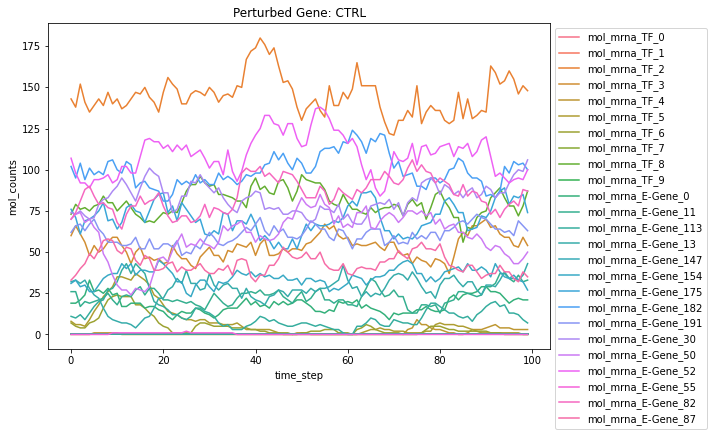

  4%|▍         | 1/26 [00:00<00:14,  1.73it/s]

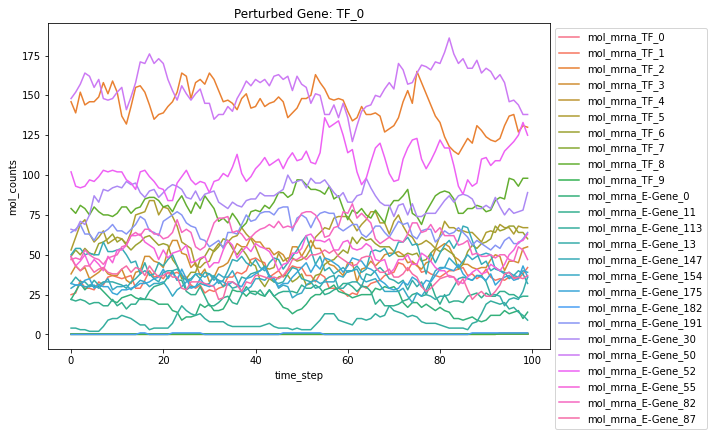

  8%|▊         | 2/26 [00:01<00:11,  2.06it/s]

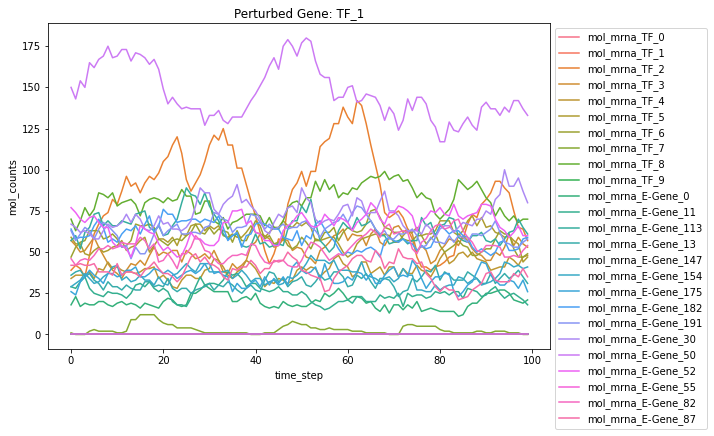

 12%|█▏        | 3/26 [00:01<00:10,  2.13it/s]

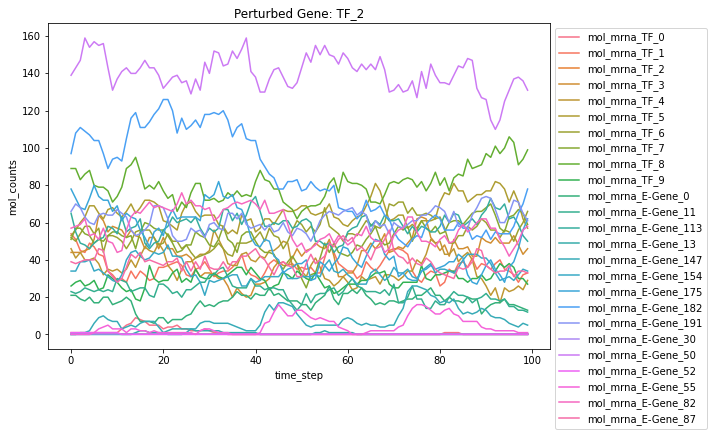

 15%|█▌        | 4/26 [00:02<00:11,  1.93it/s]

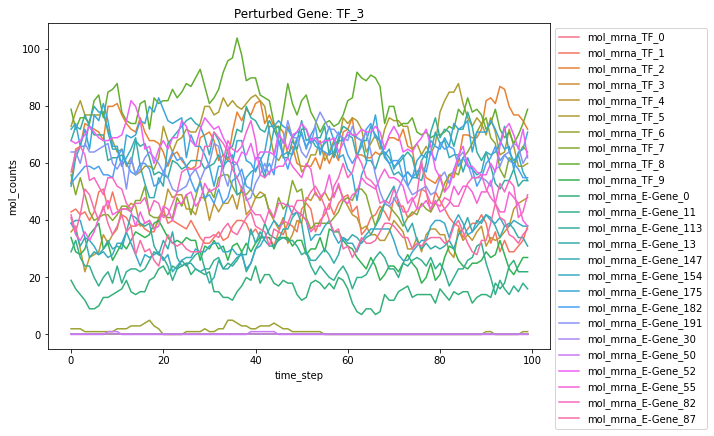

 19%|█▉        | 5/26 [00:02<00:10,  2.06it/s]

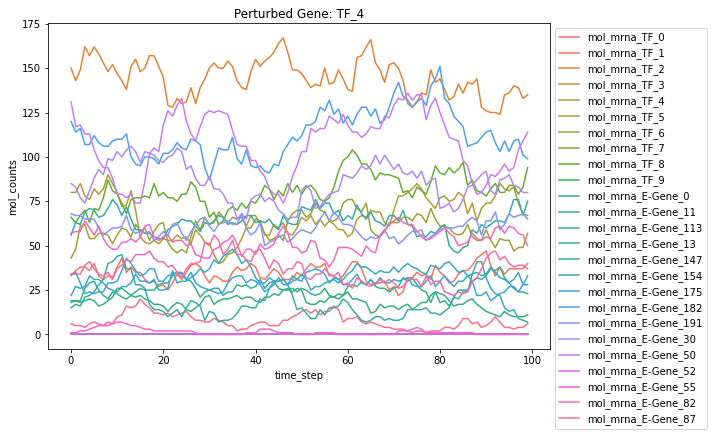

 23%|██▎       | 6/26 [00:02<00:09,  2.13it/s]

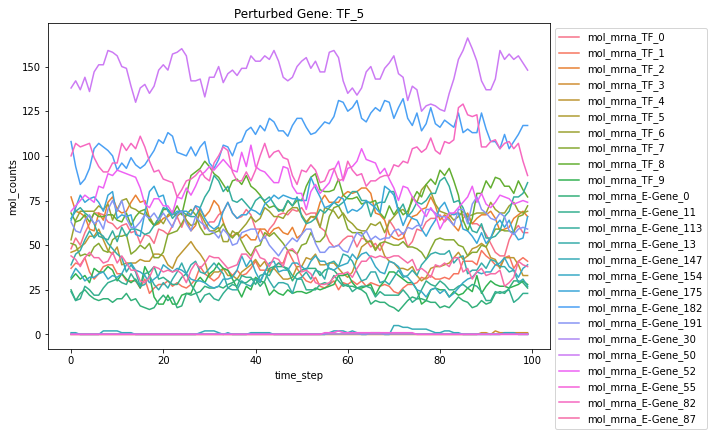

 27%|██▋       | 7/26 [00:03<00:08,  2.21it/s]

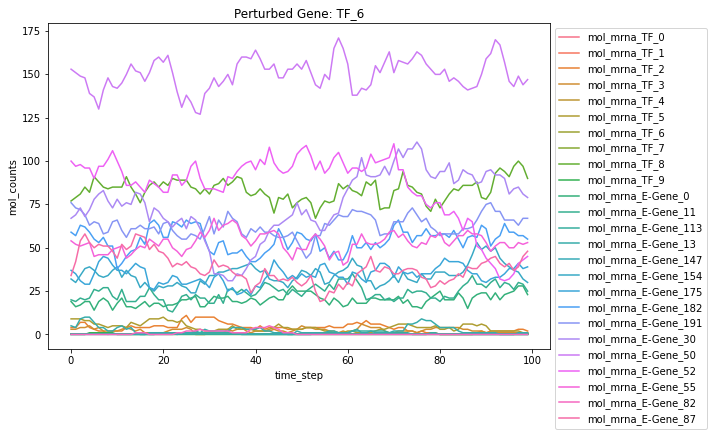

 31%|███       | 8/26 [00:03<00:07,  2.28it/s]

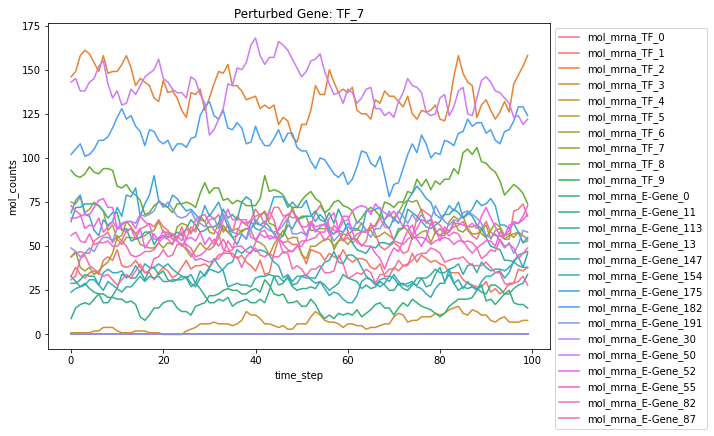

 35%|███▍      | 9/26 [00:04<00:07,  2.26it/s]

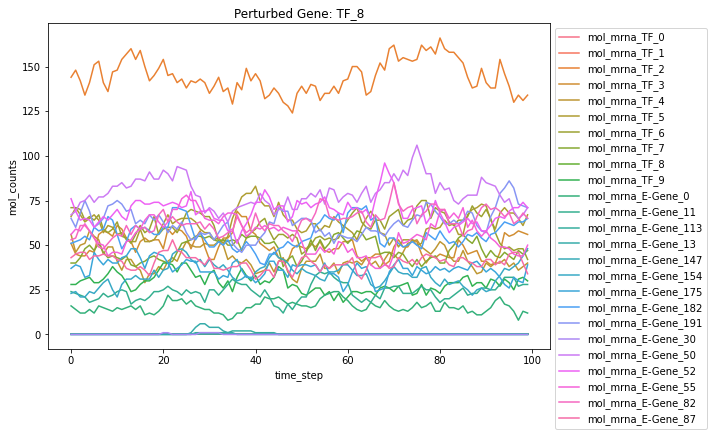

 38%|███▊      | 10/26 [00:04<00:07,  2.24it/s]

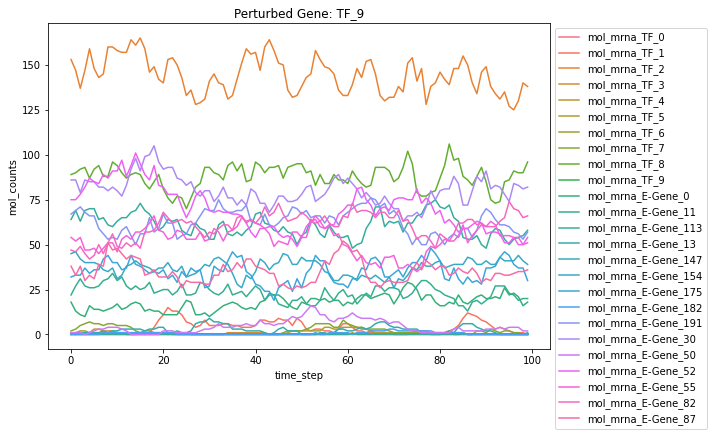

 42%|████▏     | 11/26 [00:05<00:07,  2.04it/s]

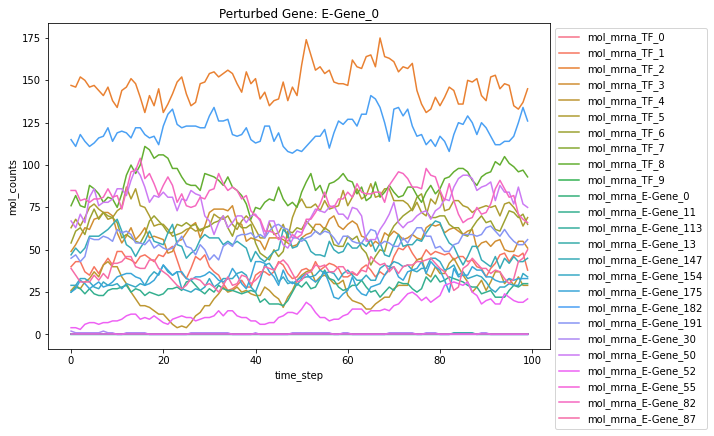

 46%|████▌     | 12/26 [00:05<00:06,  2.13it/s]

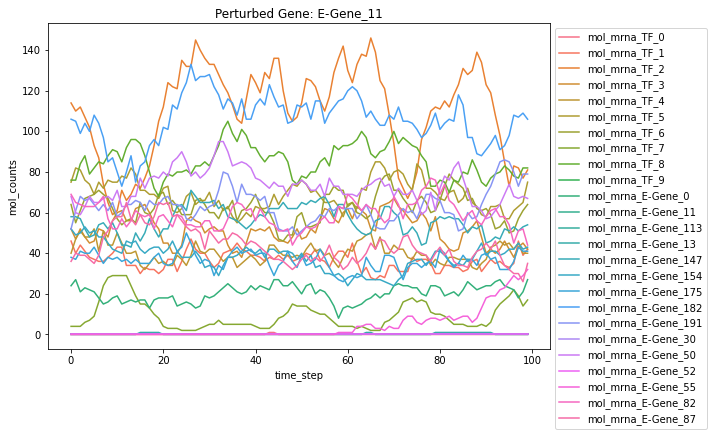

 50%|█████     | 13/26 [00:06<00:05,  2.21it/s]

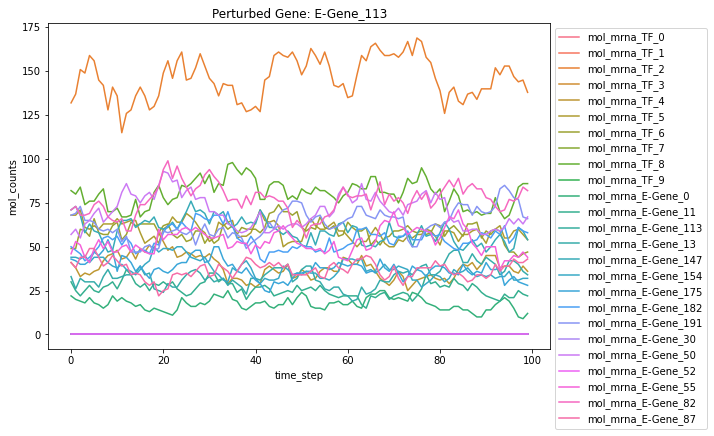

 54%|█████▍    | 14/26 [00:06<00:05,  2.28it/s]

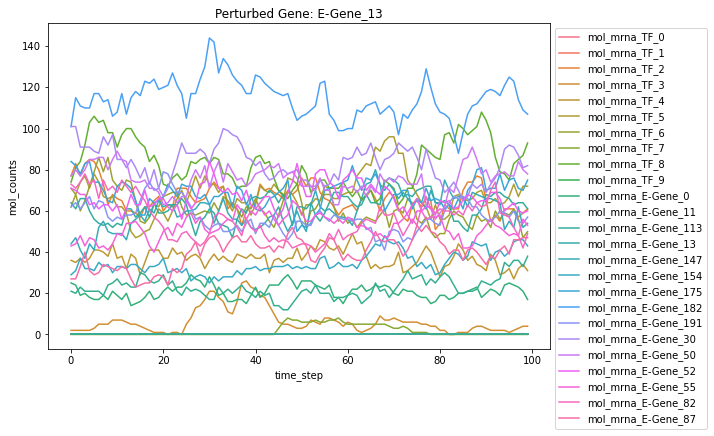

 58%|█████▊    | 15/26 [00:06<00:04,  2.32it/s]

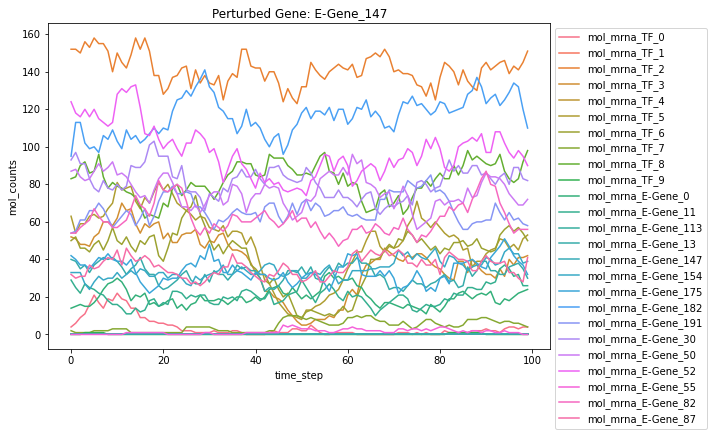

 62%|██████▏   | 16/26 [00:07<00:04,  2.33it/s]

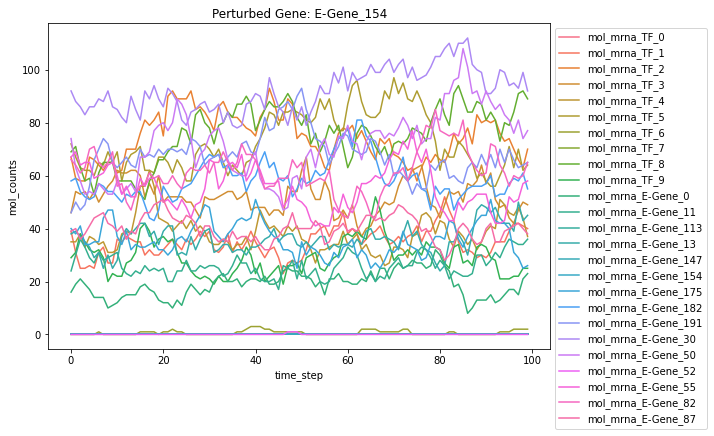

 65%|██████▌   | 17/26 [00:07<00:03,  2.36it/s]

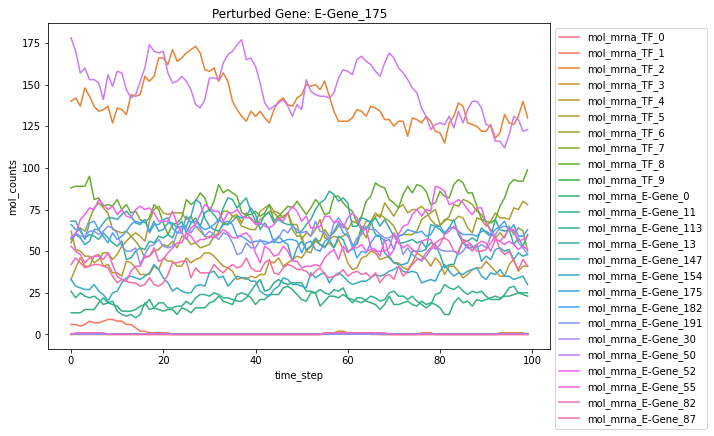

 69%|██████▉   | 18/26 [00:08<00:03,  2.14it/s]

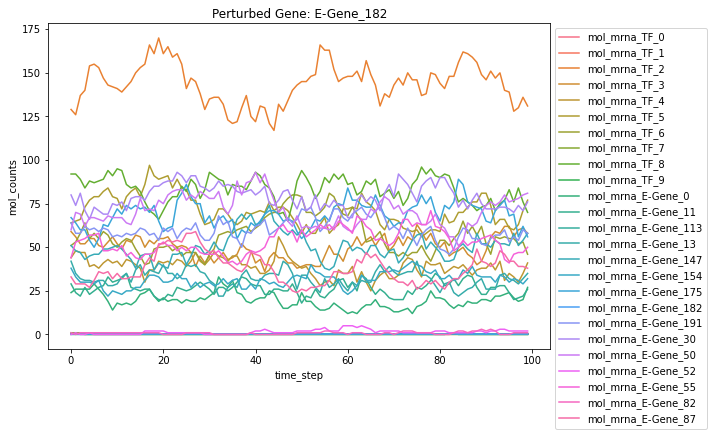

 73%|███████▎  | 19/26 [00:08<00:03,  2.21it/s]

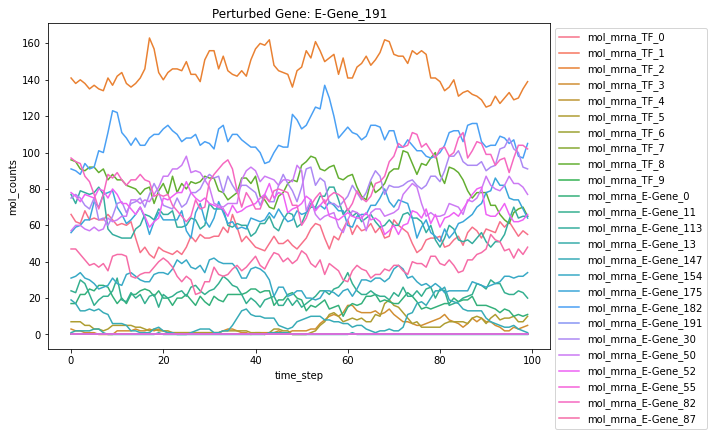

 77%|███████▋  | 20/26 [00:09<00:02,  2.26it/s]

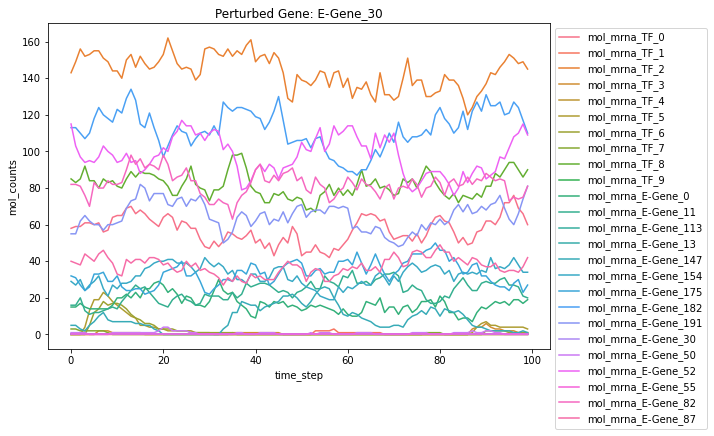

 81%|████████  | 21/26 [00:09<00:02,  2.32it/s]

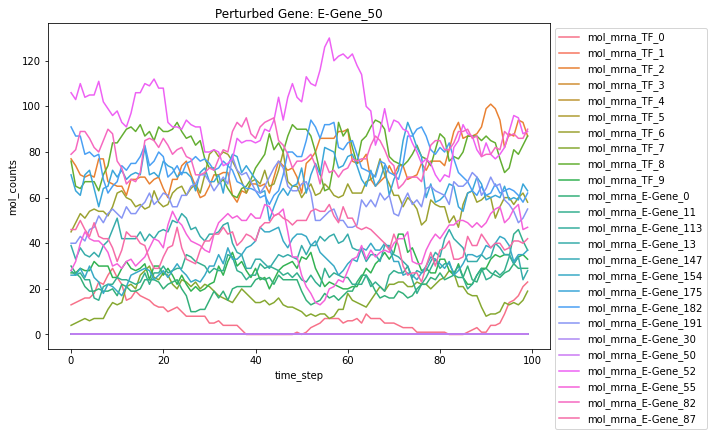

 85%|████████▍ | 22/26 [00:09<00:01,  2.33it/s]

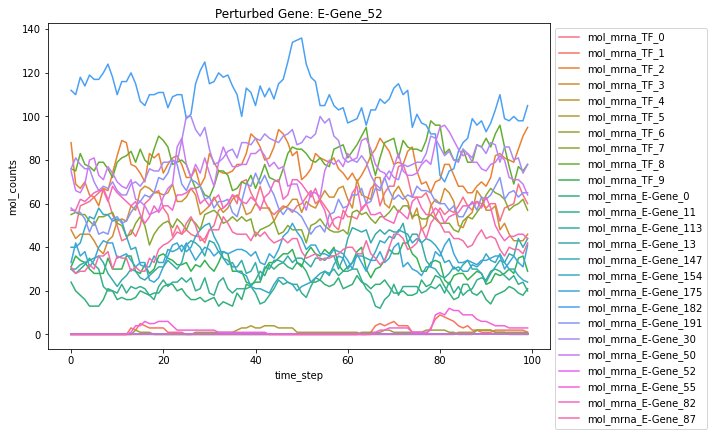

 88%|████████▊ | 23/26 [00:10<00:01,  2.36it/s]

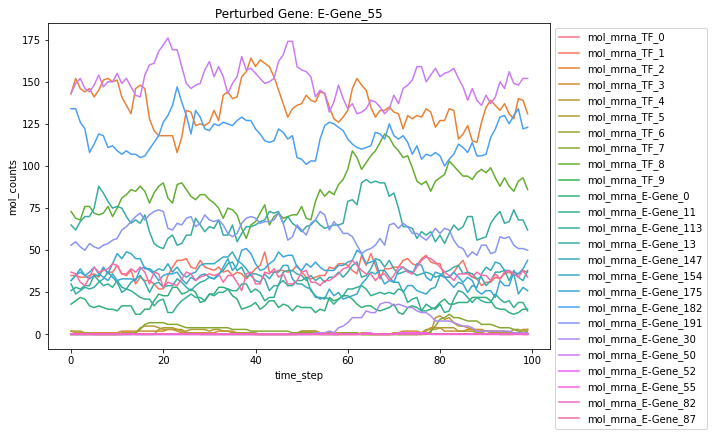

 92%|█████████▏| 24/26 [00:10<00:00,  2.39it/s]

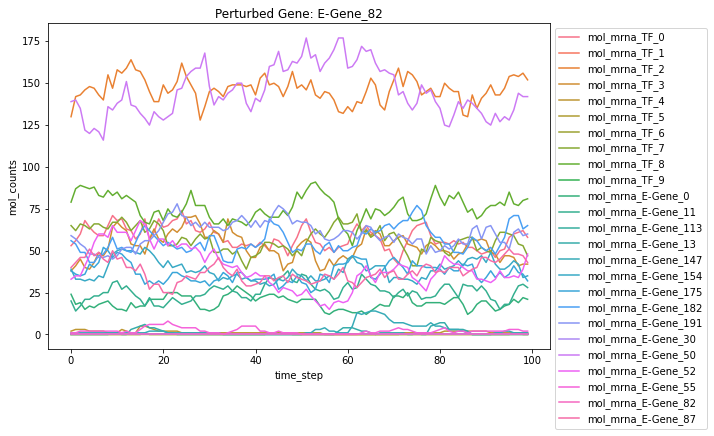

 96%|█████████▌| 25/26 [00:11<00:00,  2.14it/s]

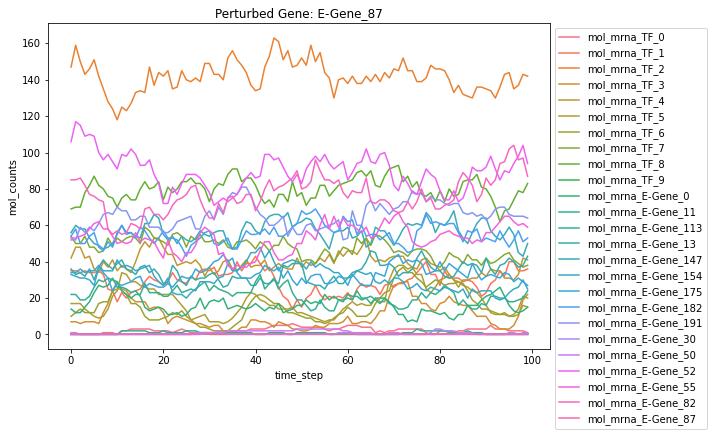

100%|██████████| 26/26 [00:11<00:00,  2.21it/s]


In [13]:
for gene in tqdm(df.perturbed_gene.unique()):
    gene_df = df.loc[df.perturbed_gene == gene]
    
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=gene_df, x='time_step', y='mol_counts', hue='mol')
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.title(f'Perturbed Gene: {gene}')
    plt.show()

In [14]:
for gene in tqdm(df.perturbed_gene.unique()):
    
    if gene == athena.ctrl_label:
        continue
    
    mol = 'mol_mrna_' + gene
    gene_df = df.loc[df.perturbed_gene == gene]
    mol_counts = gene_df.loc[gene_df.mol == mol, 'mol_counts'].unique()
    
    print (f"Perturbed Gene: {gene} Unique Counts: {mol_counts}")

100%|██████████| 26/26 [00:00<00:00, 219.17it/s]

Perturbed Gene: TF_0 Unique Counts: [0.]
Perturbed Gene: TF_1 Unique Counts: [0.]
Perturbed Gene: TF_2 Unique Counts: [0.]
Perturbed Gene: TF_3 Unique Counts: [0.]
Perturbed Gene: TF_4 Unique Counts: [0.]
Perturbed Gene: TF_5 Unique Counts: [0.]
Perturbed Gene: TF_6 Unique Counts: [0.]
Perturbed Gene: TF_7 Unique Counts: [0.]
Perturbed Gene: TF_8 Unique Counts: [0.]
Perturbed Gene: TF_9 Unique Counts: [0.]
Perturbed Gene: E-Gene_0 Unique Counts: [0.]
Perturbed Gene: E-Gene_11 Unique Counts: [0.]
Perturbed Gene: E-Gene_113 Unique Counts: [0.]
Perturbed Gene: E-Gene_13 Unique Counts: [0.]
Perturbed Gene: E-Gene_147 Unique Counts: [0.]
Perturbed Gene: E-Gene_154 Unique Counts: [0.]
Perturbed Gene: E-Gene_175 Unique Counts: [0.]
Perturbed Gene: E-Gene_182 Unique Counts: [0.]
Perturbed Gene: E-Gene_191 Unique Counts: [0.]
Perturbed Gene: E-Gene_30 Unique Counts: [0.]
Perturbed Gene: E-Gene_50 Unique Counts: [0.]
Perturbed Gene: E-Gene_52 Unique Counts: [0.]
Perturbed Gene: E-Gene_55 Unique 